## Winoground CLIP Example

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/PhD/2022 Julen Etxaniz EHU/MAL/winoground/evaluation

/content/drive/MyDrive/PhD/2022 Julen Etxaniz EHU/MAL/winoground/evaluation


# Install Dependencies

In [3]:
!pip install transformers
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 22.8 MB/s 
     |████████████████████████████████| 6.6 MB 40.5 MB/s 
     |████████████████████████████████| 101 kB 9.0 MB/s 
     |████████████████████████████████| 596 kB 53.9 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 362 kB 25.5 MB/s 
     |████████████████████████████████| 1.1 MB 36.8 MB/s 
     |████████████████████████████████| 140 kB 60.9 MB/s 
     |████████████████████████████████| 212 kB 56.5 MB/s 
     |████████████████████████████████| 127 kB 41.5 MB/s 
     |████████████████████████████████| 94 kB 2.2 MB/s 
     |████████████████████████████████| 271 kB 45.0 MB/s 
     |████████████

# Load Winoground (enter a huggingface user token or it will fail)

Easily get a token by logging into https://huggingface.co/, clicking on your user profile -> settings -> access tokens -> new token

In [4]:
def get_token():
    with open("../token.txt") as f:
        return f.read()

In [5]:
from datasets import load_dataset
# Replace with an auth token, which you can get from your huggingface account: Profile -> Settings -> Access Tokens -> New Token
auth_token = get_token()
winoground = load_dataset("facebook/winoground", use_auth_token=auth_token)["test"]

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset winoground downloaded and prepared to /root/.cache/huggingface/datasets/facebook___winoground/default/0.0.0/ce486f3e39fab90997d6f3c58c4b0103eb9c37011049ef775a465f0ab2e78d7d. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

# Load CLIP

In [6]:
from transformers import CLIPProcessor, CLIPModel
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to("cuda")
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

Downloading:   0%|          | 0.00/4.03k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/577M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/316 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/568 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/842k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/512k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.12M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/389 [00:00<?, ?B/s]

# Look at an example from Winoground and get the image-caption scores from CLIP

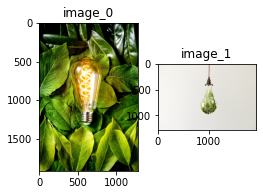

caption_0: some plants surrounding a lightbulb
caption_1: a lightbulb surrounding some plants


In [7]:
from matplotlib import pyplot as plt

def show_example(id):
    ax1 = plt.subplot(1, 3, 1)
    ax1.title.set_text('image_0')
    plt.imshow(winoground[id]["image_0"].convert("RGB"))

    ax2 = plt.subplot(1, 3, 2)
    ax2.title.set_text('image_1')
    plt.imshow(winoground[id]["image_1"].convert("RGB"))

    plt.show()

    print("caption_0:", winoground[id]["caption_0"])
    print("caption_1:", winoground[id]["caption_1"])

show_example(id=155)

In [8]:
def get_clip_scores(id):
    # Note that some images in winoground are RGBA and some are RGB. Need to convert all to RGB with .convert('RGB')
    # Note that we could run this example through CLIP as a batch, but I want to drive the point home that we get four independent image-caption scores for each example
    input_c0_i0 = clip_processor(text=[winoground[id]["caption_0"]], images=[winoground[id]["image_0"].convert("RGB")], return_tensors="pt").to("cuda")
    input_c1_i0 = clip_processor(text=[winoground[id]["caption_1"]], images=[winoground[id]["image_0"].convert("RGB")], return_tensors="pt").to("cuda")
    input_c0_i1 = clip_processor(text=[winoground[id]["caption_0"]], images=[winoground[id]["image_1"].convert("RGB")], return_tensors="pt").to("cuda")
    input_c1_i1 = clip_processor(text=[winoground[id]["caption_1"]], images=[winoground[id]["image_1"].convert("RGB")], return_tensors="pt").to("cuda")
    output_c0_i0 = clip_model(**input_c0_i0)
    output_c1_i0 = clip_model(**input_c1_i0)
    output_c0_i1 = clip_model(**input_c0_i1)
    output_c1_i1 = clip_model(**input_c1_i1)
    clip_score_c0_i0 = output_c0_i0.logits_per_image.item()
    clip_score_c1_i0 = output_c1_i0.logits_per_image.item()
    clip_score_c0_i1 = output_c0_i1.logits_per_image.item()
    clip_score_c1_i1 = output_c1_i1.logits_per_image.item()

    clip_scores = {"id": id, "c0_i0": clip_score_c0_i0, "c0_i1": clip_score_c0_i1, "c1_i0": clip_score_c1_i0, "c1_i1": clip_score_c1_i1}
    return clip_scores

clip_scores = get_clip_scores(id=155)

In [9]:
def print_scores(scores):
    print("image_0, caption_0:", scores["c0_i0"])
    print("image_0, caption_1:", scores["c1_i0"])
    print("image_1, caption_0:", scores["c0_i1"])
    print("image_1, caption_1:", scores["c1_i1"])

print("CLIP image-text match scores:")
print_scores(clip_scores)

CLIP image-text match scores:
image_0, caption_0: 32.42551803588867
image_0, caption_1: 33.01456069946289
image_1, caption_0: 32.718040466308594
image_1, caption_1: 32.888797760009766


# Get CLIP image-caption scores from the whole dataset

In [10]:
from tqdm import tqdm

def get_all_clip_scores():  
    winoground_clip_scores = []
    for id in tqdm(range(len(winoground))):
        clip_scores = get_clip_scores(id=id)
        winoground_clip_scores.append(clip_scores)
    return winoground_clip_scores

winoground_clip_scores = get_all_clip_scores()

100%|██████████| 400/400 [12:53<00:00,  1.93s/it]


In [11]:
def save_results(filename, winoground_scores):
    with open(filename, 'w') as f:
        for scores in winoground_scores:
            f.write(f'{{"label": "{scores["id"]}_c0_i0", "score": {scores["c0_i0"]}}}\n')
            f.write(f'{{"label": "{scores["id"]}_c1_i0", "score": {scores["c1_i0"]}}}\n')
            f.write(f'{{"label": "{scores["id"]}_c0_i1", "score": {scores["c0_i1"]}}}\n')
            f.write(f'{{"label": "{scores["id"]}_c1_i1", "score": {scores["c1_i1"]}}}\n')

save_results("../results/clip_b32.jsonl", winoground_clip_scores)

# Define the text, image, and group metrics, and compute the overall performance of CLIP

In [12]:
def text_correct(result):
    return result["c0_i0"] > result["c1_i0"] and result["c1_i1"] > result["c0_i1"]

def image_correct(result):
    return result["c0_i0"] > result["c0_i1"] and result["c1_i1"] > result["c1_i0"]

def group_correct(result):
    return image_correct(result) and text_correct(result)

def print_performance(winoground_scores):
    text_correct_count = 0
    image_correct_count = 0
    group_correct_count = 0
    for result in winoground_scores:
        text_correct_count += 1 if text_correct(result) else 0
        image_correct_count += 1 if image_correct(result) else 0
        group_correct_count += 1 if group_correct(result) else 0

    denominator = len(winoground_scores)
    print("text score:", text_correct_count/denominator)
    print("image score:", image_correct_count/denominator)
    print("group score:", group_correct_count/denominator)

print("CLIP scores:")
print_performance(winoground_clip_scores)

CLIP scores:
text score: 0.3075
image score: 0.1025
group score: 0.0825
